In [95]:
!pip3 install pdpbox

     |████████████████████████████████| 34.0 MB 42 kB/s 
     |████████████████████████████████| 13.1 MB 6.6 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=4cc46a880f83baea930307b203e2c148d8b8075315b4d9e3f2e563d7c3a3ed9d
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [91]:
!pip install shap

     |████████████████████████████████| 371 kB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509259 sha256=d2fd810b8fb3e5b4106fbc115762030a5e57358c70ef8ffc602e22234e67eee5
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [55]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 385 kB/s 


In [92]:
from google.colab import files
import io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot

In [1]:
uploaded = files.upload()

Saving CO2_emission.csv to CO2_emission.csv


In [146]:
df = pd.read_csv(io.BytesIO(uploaded['CO2_emission.csv']))

In [147]:
df.head()

,Model_Year,Make,Model,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Consumption_in_City(L/100 km),Fuel_Consumption_in_City_Hwy(L/100 km),Fuel_Consumption_comb(L/100km),CO2_Emissions,Smog_Level
0,2021,Acura,ILX,Compact,2.4,4,AM8,9.9,7.0,8.6,199,3
1,2021,Acura,NSX,Two-seater,3.5,6,AM9,11.1,10.8,11.0,256,3
2,2021,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,11.0,8.6,9.9,232,6
3,2021,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,11.3,9.1,10.3,242,6
4,2021,Acura,TLX SH-AWD,Compact,2.0,4,AS10,11.2,8.0,9.8,230,7


In [6]:
# target
target = 'CO2_Emissions'

# 기준모델
baseline_predict = df[target].mean()
print('target(CO2_Emmisions)의 기준모델: ', baseline_predict)

target(CO2_Emmisions)의 기준모델:  258.52941176470586


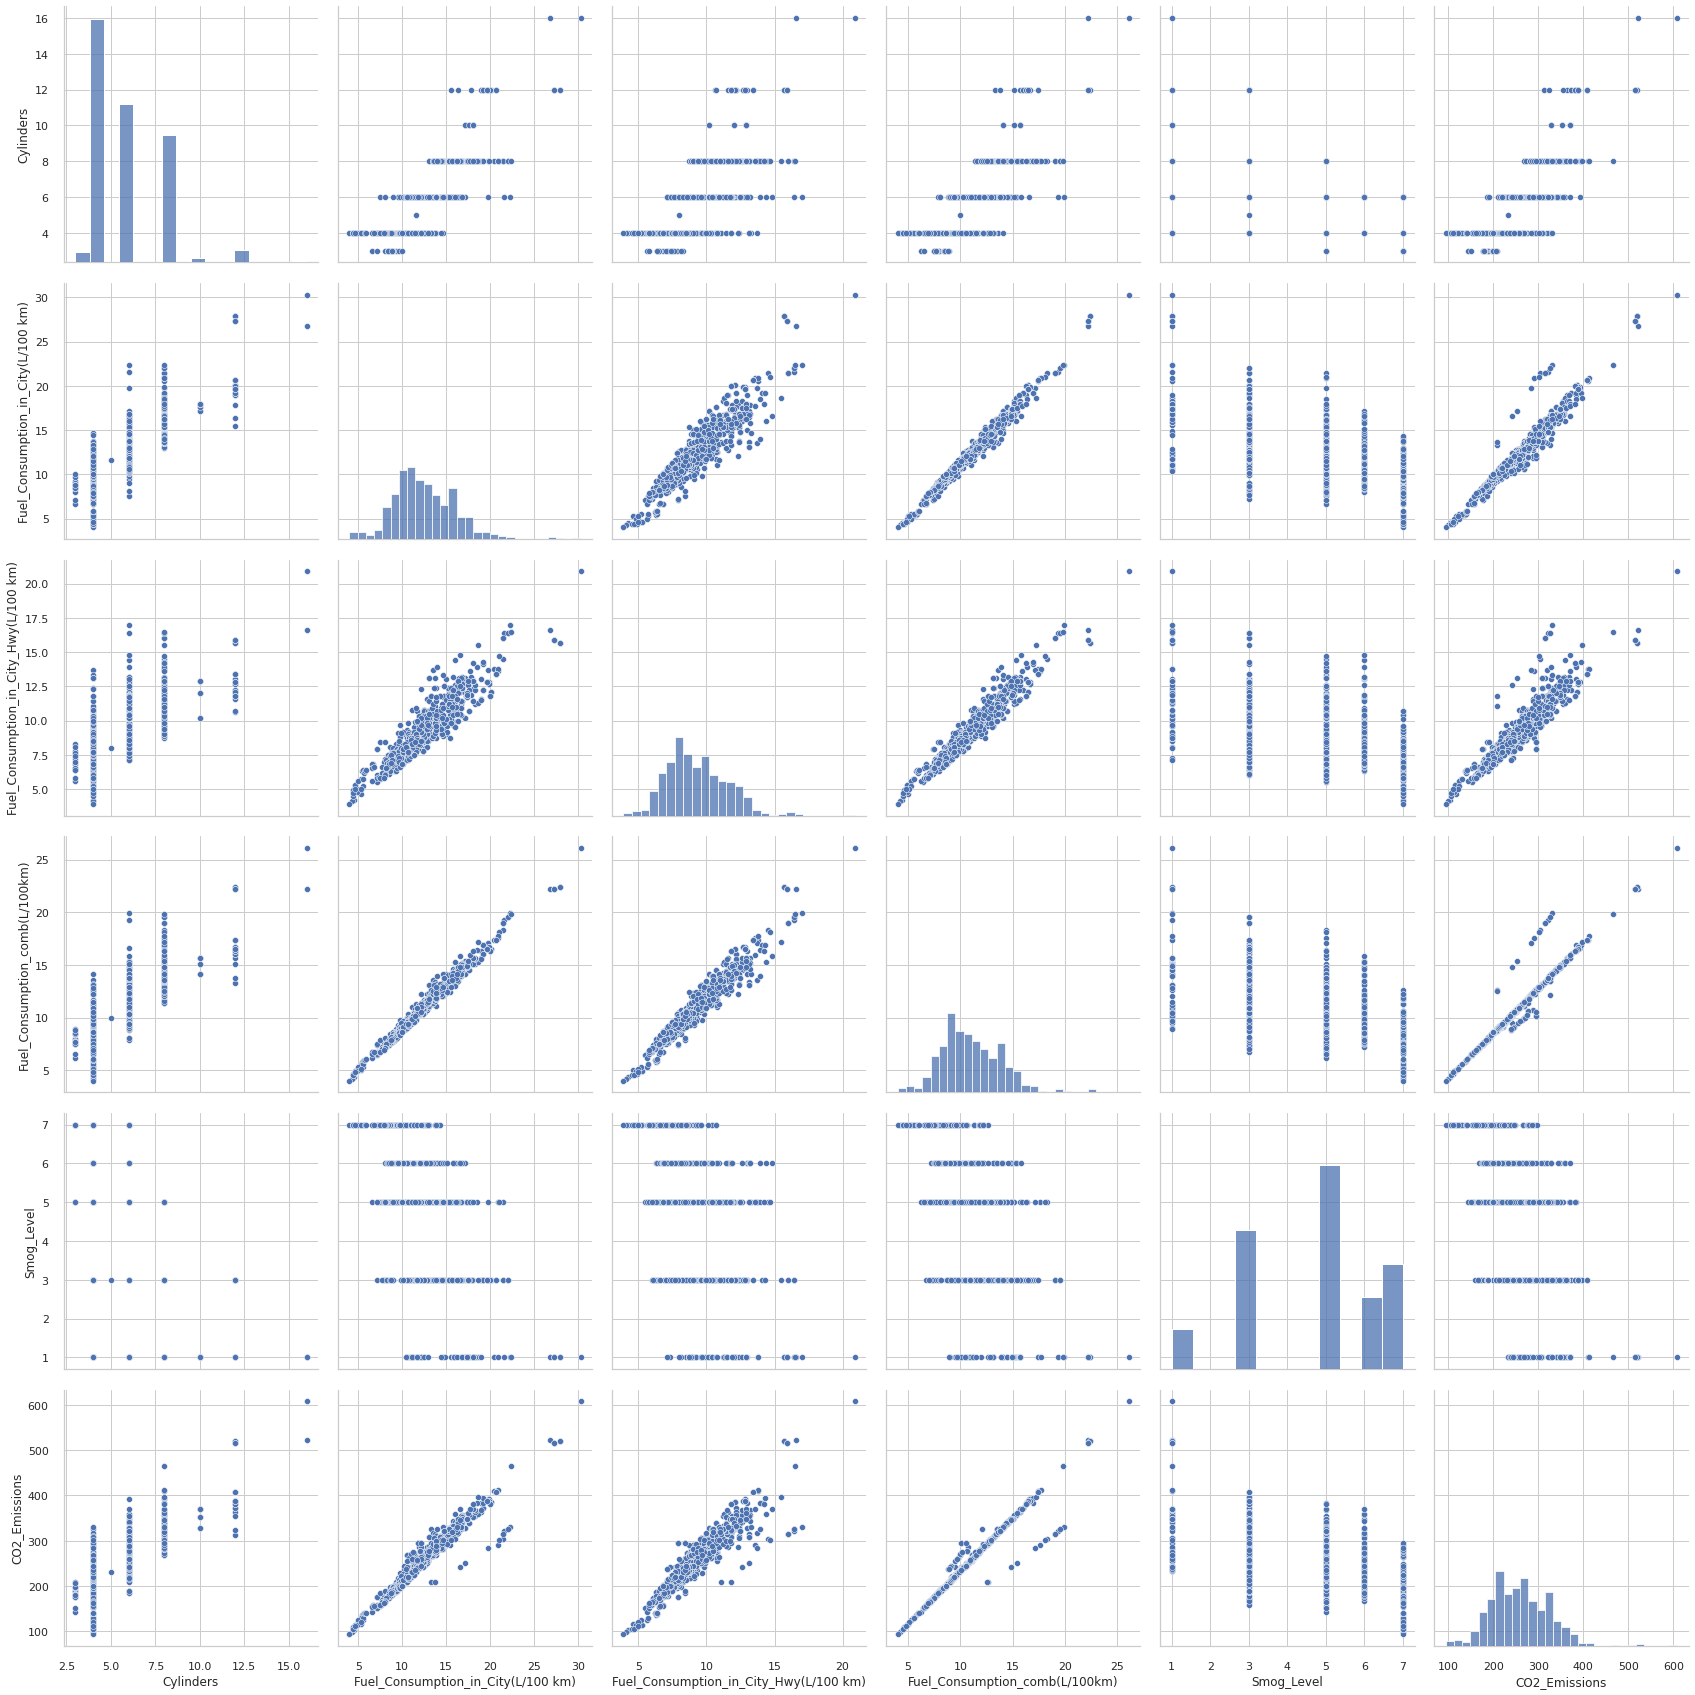

In [23]:
cols = ['Cylinders', 'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_in_City_Hwy(L/100 km)', 'Fuel_Consumption_comb(L/100km)', 'Smog_Level', 'CO2_Emissions']

sns.set(style='whitegrid', context='notebook')
sns.pairplot(df[cols], height=4);

In [26]:
# CO2_Emissions과 관계가 낮아보이는 Smog_Level, Model_Year를 제거
df.drop(['Model_Year', 'Smog_Level'], axis=1, inplace=True)

In [142]:
# 8:2로 train, test 데이터 분리
train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=2)

# 선형적 관계를 갖은 feature들만 선택
feature1 = ['Engine_Size', 'Cylinders', 'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_in_City_Hwy(L/100 km)', 'Fuel_Consumption_comb(L/100km)']

X_train = train[feature1]
y_train = train[target]
X_test = test[feature1]
y_test = test[target]

In [143]:
LinReg = LinearRegression()
LinReg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
# Linear Regression의 훈련, 테스트셋 에러
mae = mean_absolute_error(y_train, LinReg.predict(X_train))
print(f'훈련 MAE 에러: {mae:.2f}')

mae = mean_absolute_error(y_test, LinReg.predict(X_test))
print(f'테스트 MAE 에러: {mae:.2f}')

훈련 MAE 에러: 6.73
테스트 MAE 에러: 7.71


In [63]:
tree = DecisionTreeRegressor(criterion="mae")
tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [64]:
# Decision Tree Regressor의 훈련, 테스트셋 에러
mae = mean_absolute_error(y_train, tree.predict(X_train))
print(f'훈련 MAE 에러: {mae:.2f}')

mae = mean_absolute_error(y_test, tree.predict(X_test))
print(f'테스트 MAE 에러: {mae:.2f}')

훈련 MAE 에러: 0.03
테스트 MAE 에러: 3.45


In [133]:
# categorical feature를 사용하여 feature 재구성
feature2 = ['Make', 'Vehicle_Class', 'Engine_Size', 'Cylinders', 'Transmission', 'Fuel_Consumption_in_City(L/100 km)', 'Fuel_Consumption_in_City_Hwy(L/100 km)', 'Fuel_Consumption_comb(L/100km)']

X_train = train[feature2]
y_train = train[target]
X_test = test[feature2]
y_test = test[target]

pipe_tree = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeRegressor(criterion="mae")
)
pipe_tree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Make', 'Vehicle_Class', 'Transmission'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Make',
                                          'data_type': dtype('O'),
                                          'mapping': BMW               1
Mercedes-Benz     2
GMC               3
Honda             4
Porsche           5
Ford              6
Dodge             7
Rolls-Royce       8
Volkswagen        9
Lexus            10
Audi             11
Alfa Romeo       12
Chevrolet        13
Subaru           14
Maserati...
dtype: int64}],
                                return_df=True, verbose=0)),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae',
                                       max_depth=None, max_features=No

In [134]:
# Categorical Feature가 포함된 decision tree model 에러
mae = mean_absolute_error(y_train, pipe_tree.predict(X_train))
print(f'훈련 MAE 에러: {mae:.2f}')

mae = mean_absolute_error(y_test, pipe_tree.predict(X_test))
print(f'테스트 MAE 에러: {mae:.2f}')

훈련 MAE 에러: 0.01
테스트 MAE 에러: 3.10


In [135]:
# Random Forest가 적용된 모델
pipe_forest = make_pipeline(
    OrdinalEncoder(), 
    RandomForestRegressor(criterion="mae", random_state=2)
)
pipe_forest.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Make', 'Vehicle_Class', 'Transmission'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Make',
                                          'data_type': dtype('O'),
                                          'mapping': BMW               1
Mercedes-Benz     2
GMC               3
Honda             4
Porsche           5
Ford              6
Dodge             7
Rolls-Royce       8
Volkswagen        9
Lexus            10
Audi             11
Alfa Romeo       12
Chevrolet        13
Subaru           14
Maserati...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mae', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                     

In [136]:
# Categorical Feature가 포함된 random forest model 에러
mae = mean_absolute_error(y_train, pipe_forest.predict(X_train))
print(f'훈련 MAE 에러: {mae:.2f}')

mae = mean_absolute_error(y_test, pipe_forest.predict(X_test))
print(f'테스트 MAE 에러: {mae:.2f}')

훈련 MAE 에러: 1.50
테스트 MAE 에러: 3.43


In [137]:

dists = {
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, 40, None], 
    'randomforestregressor__min_samples_split': [2, 4, 8],
    'randomforestregressor__min_samples_leaf': [1, 2, 4, 8]
}

clf = RandomizedSearchCV(
    pipe_forest, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


In [139]:
print('Best parameters: ', clf.best_params_)
pipe_forest_CV = clf.best_estimator_

mae = mean_absolute_error(y_train, pipe_forest_CV.predict(X_train))
print(f'훈련 MAE 에러: {mae:.2f}')

mae = mean_absolute_error(y_test, pipe_forest_CV.predict(X_test))
print(f'테스트 MAE 에러: {mae:.2f}')

Best parameters:  {'randomforestregressor__max_depth': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 479}
훈련 MAE 에러: 1.65
테스트 MAE 에러: 3.44


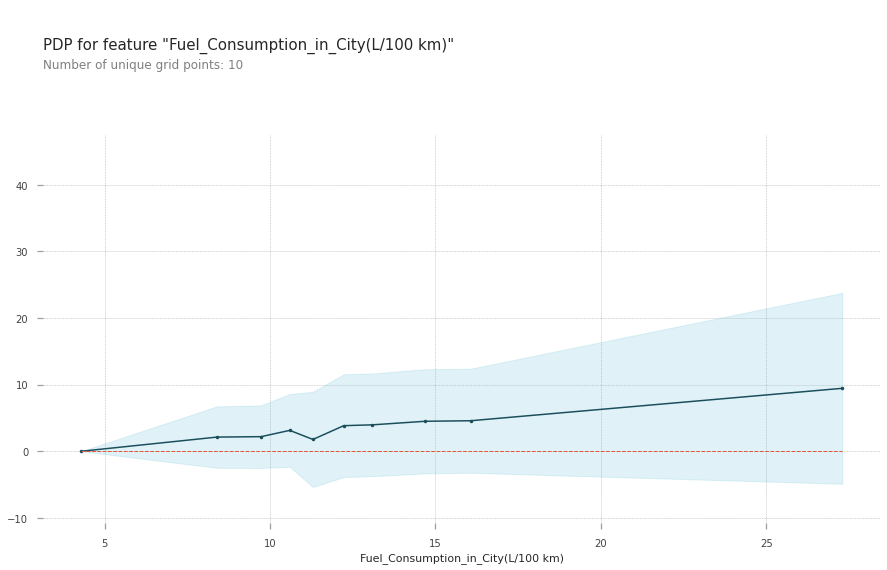

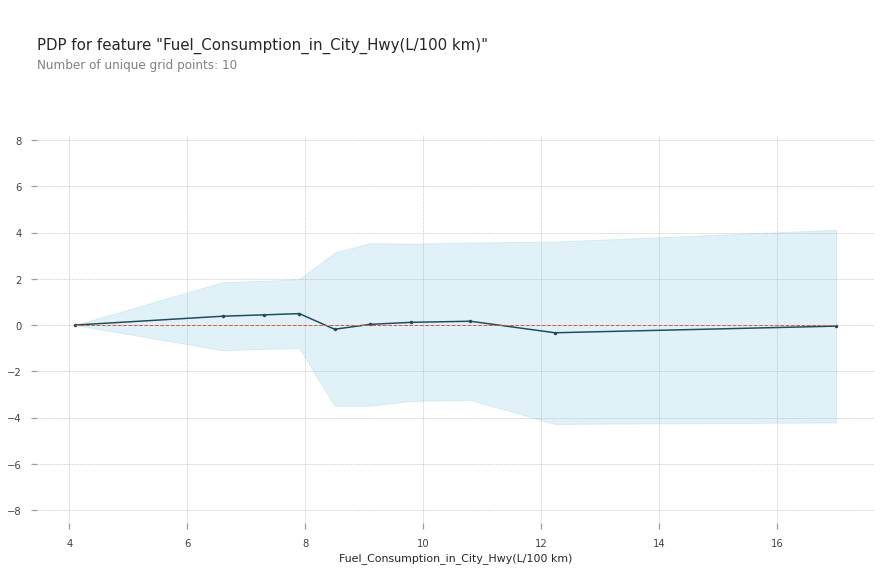

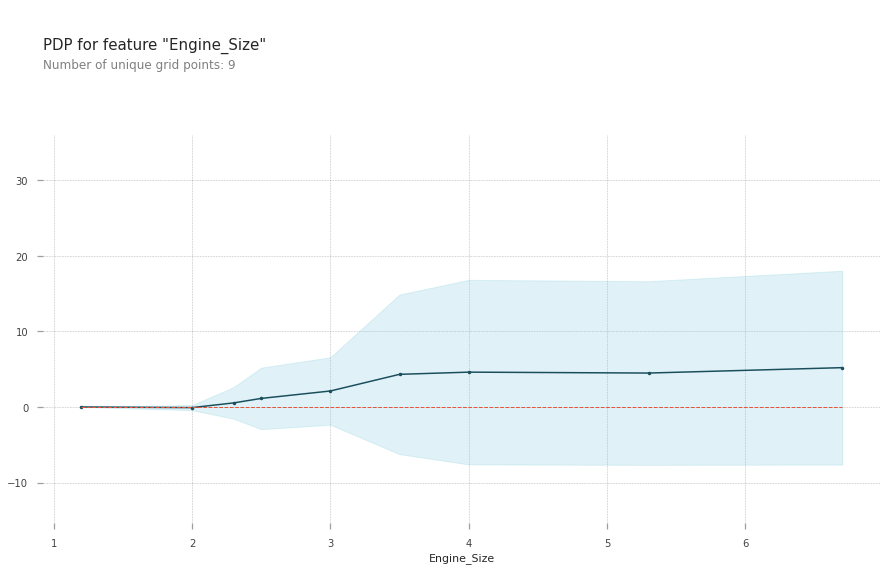

In [140]:
### Draw PDP plots ###
feature = 'Fuel_Consumption_in_City(L/100 km)'
isolated = pdp_isolate(
    model=pipe_forest_CV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

feature = 'Fuel_Consumption_in_City_Hwy(L/100 km)'
isolated = pdp_isolate(
    model=pipe_forest_CV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

feature = 'Engine_Size'
isolated = pdp_isolate(
    model=pipe_forest_CV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

